# Malta news tweets

**Login and Class Creation**

In [ ]:
#@title
from google.colab import drive
drive.mount("/content/drive")

import os
pathin = "/content/drive/MyDrive/Colab Notebooks/Projects/Twitter"
os.chdir(pathin)

import pandas as pd
login = pd.read_csv("LoginTwitter - Sheet1.csv")

import tweepy
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from time import sleep
import nltk
nltk.download('punkt')

import sqlite3
import re
import matplotlib.pyplot as plt

class twitter_bot:
    def __init__(self):
        self.CONSUMER_KEY = login["CONSUMER_KEY"][0]
        self.CONSUMER_SECRET = login["CONSUMER_SECRET"][0]
        self.ACCESS_TOKEN = login["ACCESS_TOKEN"][0]
        self.ACCESS_TOKEN_SECRET = login["ACCESS_TOKEN_SECRET"][0]
    def authenticate(self):
        auth = tweepy.OAuthHandler(self.CONSUMER_KEY,self.CONSUMER_SECRET)
        auth.set_access_token(self.ACCESS_TOKEN,self.ACCESS_TOKEN_SECRET)
        api = tweepy.API(auth)
        return api
    def search_tweet(self,keyword):
        api = self.authenticate()
        tweets = api.search(q=keyword+" -filter:retweets", lang="en",)
        texts = [i.text for i in tweets]
        sentiment = []
        for j in texts:
            blob = TextBlob(j)
            senti = [sentence.sentiment.polarity for sentence in blob.sentences]
            sentiment.append(min(senti))
        user = [i.user.name for i in tweets]
        timestamp = [i.created_at for i in tweets]
        n = [len(i.retweets()) for i in tweets]
        result = pd.DataFrame({"timestamp":timestamp,"user":user,"tweet":texts,"sentiment":sentiment,"retweets":n})
        return result
    def get_usertimeline(self,user):
        api = self.authenticate()
        tweets = api.user_timeline(screen_name=user,include_rts=False)
        texts = [i.text for i in tweets]
        sentiment = []
        for j in texts:
            blob = TextBlob(j)
            senti = [sentence.sentiment.polarity for sentence in blob.sentences]
            sentiment.append(min(senti))
        user = [i.user.name for i in tweets]
        timestamp = [i.created_at for i in tweets]
        n = [len(i.retweets()) for i in tweets]
        result = pd.DataFrame({"timestamp":timestamp,"user":user,"tweet":texts,"sentiment":sentiment,"retweets":n})
        return result

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**db append**

In [ ]:
twitter_accounts_all = ["LovinMalta","maltatoday","IndependentMlt","TheTimesofMalta","netnewsmalta","ONE_news_Malta"]

In [ ]:
#@title
for i in twitter_accounts:
  tweetdata = twitter_bot().get_usertimeline(i)
  sleep(20)
  db=sqlite3.connect("tweetMLT.db")
  db.row_factory=sqlite3.Row
  db.execute("""create table if not exists 
    tweets(   tweet              BLOB     PRIMARY KEY NOT NULL,
              timestamp          BLOB     ,
              user               BLOB     ,
              sentiment          BLOB     ,
              retweets           BLOB  
         );""")
  for j in range(0,len(tweetdata)):
    try:
      db.execute("INSERT into tweets(tweet,timestamp,user,sentiment,retweets) values('{}','{}','{}',{},{})".format(tweetdata["tweet"][j].replace("'","").replace('"',''),tweetdata["timestamp"][j],tweetdata["user"][j],tweetdata["sentiment"][j],tweetdata["retweets"][j]))
    except Exception as e:
      print(str(e))
  db.commit()

The below plot displays the tweets over time. The size of the marker shows the total number of tweets (original + retweets)

In [ ]:
#@title
db_tweets = pd.read_sql("select * from tweets",db)

hov_text = []
for i in range(len(db_tweets)):
  hov_text.append("user: {} tweet: {} ".format(db_tweets["user"][i],db_tweets["tweet"][i]))

db_tweets["tweet_sentimet"] = (db_tweets["sentiment"]+1)*((db_tweets["sentiment"]+1)*10)
db_tweets["total_tweets"] = db_tweets["retweets"] + 1

import datetime
db_tweets = db_tweets[db_tweets["timestamp"] > str(datetime.date.today() - datetime.timedelta(days=0))]

import plotly.express as px

fig = px.scatter(db_tweets, x="timestamp", y="user", color="user", size="total_tweets",hover_name="tweet")                                     
             
fig.update_traces(marker=dict(line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

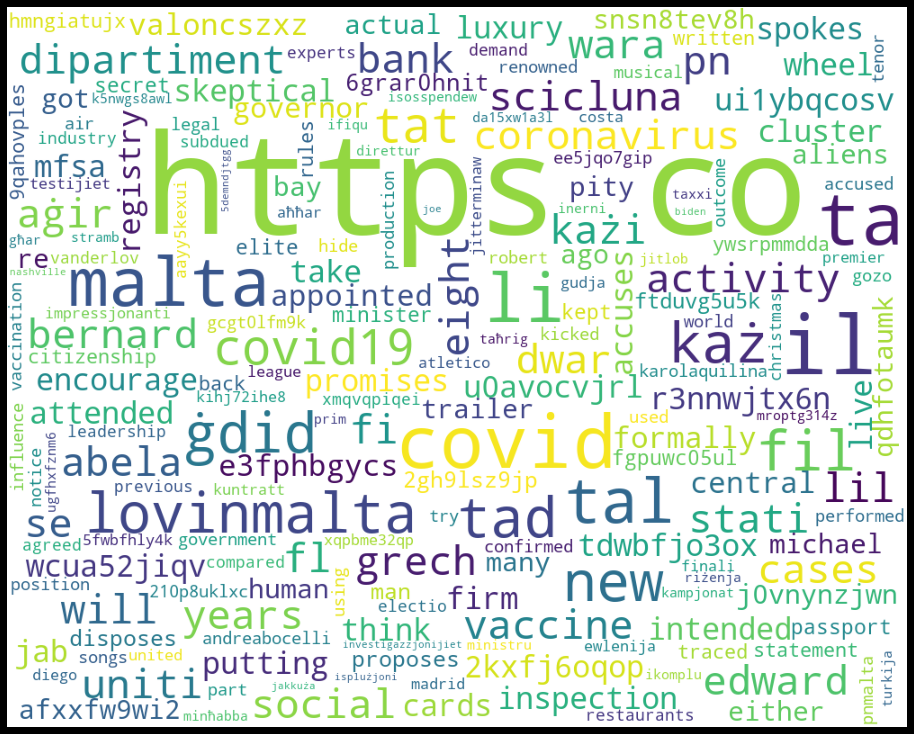

In [ ]:
#@WorldCloud
text = " ".join(tweet for tweet in db_tweets["tweet"])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white",width=1000, height=800).generate(text.lower())
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
db_tweets

,tweet,timestamp,user,sentiment,retweets,tweet_sentimet,total_tweets
0,#Malta #LovinMalta #COVID19 \n\nhttps://t.co/2...,2020-12-29 10:49:03,Lovin Malta,0.000000,0,10.000000,1
1,#Malta #LovinMalta \n\nhttps://t.co/UI1YBQcoSV,2020-12-29 10:30:24,Lovin Malta,0.000000,1,10.000000,2
2,Do you think Malta will live up to these promi...,2020-12-29 10:00:27,Lovin Malta,0.000000,1,10.000000,2
3,The registry is intended to encourage those sk...,2020-12-29 09:44:57,Lovin Malta,-0.500000,0,2.500000,1
19,Luxury cards firm accuses MFSA of ‘putting spo...,2020-12-29 12:49:33,MaltaToday,-0.031818,0,9.373760,1
20,COVID-19: 115 new cases; cluster of eight atte...,2020-12-29 11:56:33,MaltaToday,0.056566,0,11.163310,1
21,Edward Scicluna formally appointed as Central ...,2020-12-29 11:17:33,MaltaToday,0.000000,0,10.000000,1
22,Either they were human… or we’re aliens https:...,2020-12-29 06:54:03,MaltaToday,0.000000,0,10.000000,1
23,We got an actual vaccine trailer. Pity Michael...,2020-12-29 06:14:02,MaltaToday,0.000000,3,10.000000,4
24,"2020: Man proposes, COVID disposes https://t.c...",2020-12-29 06:01:04,MaltaToday,0.000000,1,10.000000,2
